# Mass Transfer (MT)
March 17th, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import linregress
import math
import warnings
warnings.filterwarnings('ignore')

### Reading in Data from .csv

In [3]:
df_mass = pd.read_csv("data/mass_data_processed.csv")
df_anemometer = pd.read_csv("data/anemometer_data_processed.csv")
df_tc = pd.read_csv("data/tc_data_processed.csv")

In [4]:
df_mass

,temperature,time,mass,time.1,mass.1,delta_mass
0,140,0,80,0,0.080,NaN
1,140,3,72,180,0.072,-0.008
2,140,6,66,360,0.066,-0.006
3,140,9,60,540,0.060,-0.006
4,140,12,56,720,0.056,-0.004
5,140,15,52,900,0.052,-0.004
6,140,18,49,1080,0.049,-0.003
7,140,21,46,1260,0.046,-0.003
8,140,24,43,1440,0.043,-0.003
9,133,0,31,0,0.031,NaN


## Analysis Question 1
Calculate measured evaporation rates as mass fluxes using units of kg H2O/m²·s.

In [5]:
area_tray = 0.555 * 0.200
time_elapsed = df_mass["time.1"]
df_mass["evaporative_flux"] = df_mass["delta_mass"] / area_tray * time_elapsed
df_mass

,temperature,time,mass,time.1,mass.1,delta_mass,evaporative_flux
0,140,0,80,0,0.080,NaN,NaN
1,140,3,72,180,0.072,-0.008,-12.972973
2,140,6,66,360,0.066,-0.006,-19.459459
3,140,9,60,540,0.060,-0.006,-29.189189
4,140,12,56,720,0.056,-0.004,-25.945946
5,140,15,52,900,0.052,-0.004,-32.432432
6,140,18,49,1080,0.049,-0.003,-29.189189
7,140,21,46,1260,0.046,-0.003,-34.054054
8,140,24,43,1440,0.043,-0.003,-38.918919
9,133,0,31,0,0.031,NaN,NaN


## Analysis Question 2
Use Eqs. (5) and (6) and appropriate fluid properties to calculate an average for the concentration and the temperature gradients at the evaporating surface normalized along the length of the entire plate (ignoring at this point that the gradients are functions of position along the length of the pan).

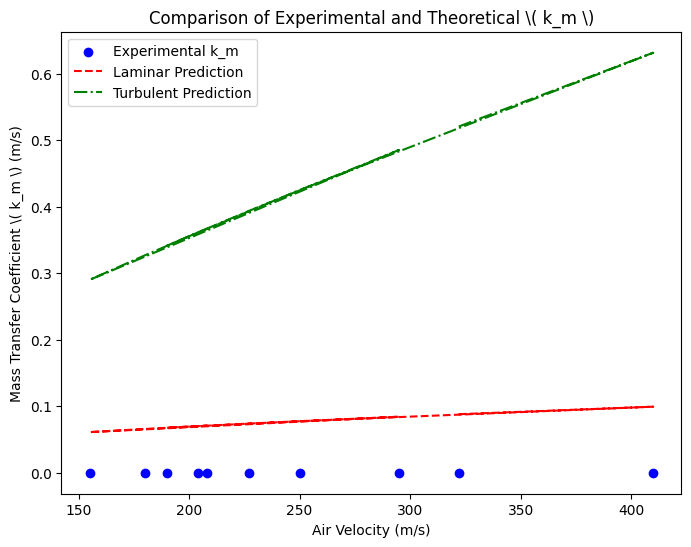

,temperature,distance,relative_humidity,air_velocity,temperature.1,humidity_ratio,water_vapor_concentration,Re,Sc,k_m_lam,k_m_turb
0,140,4,25.3,420.0,84.2,0.210664,6.132994,15540000.0,0.62,0.100540,0.644016
1,140,8,25.3,NaN,84.2,0.210664,6.132994,NaN,0.62,NaN,NaN
2,140,12,25.3,322.0,84.2,0.210664,6.132994,11914000.0,0.62,0.088032,0.520693
3,140,16,25.3,NaN,84.2,0.210664,6.132994,NaN,0.62,NaN,NaN
4,140,20,25.3,410.0,84.2,0.210664,6.132994,15170000.0,0.62,0.099336,0.631720
5,133,4,27.7,250.0,81.2,0.238304,7.057248,9250000.0,0.62,0.077568,0.425255
6,133,8,27.7,NaN,81.2,0.238304,7.057248,NaN,0.62,NaN,NaN
7,133,12,27.7,190.0,81.2,0.238304,7.057248,7030000.0,0.62,0.067622,0.341429
8,133,16,27.7,NaN,81.2,0.238304,7.057248,NaN,0.62,NaN,NaN
9,133,20,27.7,334.0,81.2,0.238304,7.057248,12358000.0,0.62,0.089657,0.536160


In [14]:
k_air = 0.026  # Thermal conductivity of air (W/m·K)
hv = 2.26e6  # Heat of vaporization of water (J/kg)
D_AB = 2.5e-5  # Diffusivity of water in air (m²/s)
R = 8.314  # Gas constant (J/mol·K)
P_air = 1.0e5  # Atmospheric pressure (Pa)
T_air = 300  # air temperature (K)
MW_H2O = 18.015  # Molar mass
MW_air = 28.97
char_length = 0.555 # length of tray (meters)

df_mass["evaporative_flux"] = df_mass["delta_mass"] / ((area_tray) * df_mass["time.1"])

# Compute water vapor concentration using relative humidity
T_air = df_anemometer["temperature"] + 273.15  # Convert temperature to Kelvin
df_anemometer["humidity_ratio"] = 0.622 * df_anemometer["relative_humidity"] / (100 - df_anemometer["relative_humidity"])
df_anemometer["water_vapor_concentration"] = (df_anemometer["humidity_ratio"] * P_air) / (R * T_air)

# Compute experimental mass transfer coefficient k_m
C_A_s = df_anemometer["water_vapor_concentration"].iloc[0]  # At water surface
C_A_e = df_anemometer["water_vapor_concentration"].mean()  # Bulk air concentration
df_mass["k_m_exp"] = df_mass["evaporative_flux"] / (C_A_s - C_A_e)

# Compute Reynolds and Schmidt numbers
df_anemometer["Re"] = (df_anemometer["air_velocity"] * char_length) / (1.5e-5)  # Air kinematic viscosity (m²/s)
df_anemometer["Sc"] = 0.62  # Schmidt number for water vapor in air at ~25°C

# Compute theoretical k_m using boundary-layer correlations
df_anemometer["k_m_lam"] = 0.664 * (D_AB / char_length) * df_anemometer["Re"]**0.5 * df_anemometer["Sc"]**(1/3)
df_anemometer["k_m_turb"] = 0.0296 * (D_AB / char_length) * df_anemometer["Re"]**(4/5) * df_anemometer["Sc"]**(1/3)

# Ensure air_velocity and k_m_exp have the same length by dropping NaN values
valid_indices = df_anemometer["air_velocity"].notna() & df_mass["k_m_exp"].notna()

plt.figure(figsize=(8, 6))
plt.scatter(df_anemometer["air_velocity"][valid_indices], df_mass["k_m_exp"][valid_indices], label="Experimental k_m", color="b", marker="o")
plt.plot(df_anemometer["air_velocity"][valid_indices], df_anemometer["k_m_lam"][valid_indices], label="Laminar Prediction", linestyle="--", color="r")
plt.plot(df_anemometer["air_velocity"][valid_indices], df_anemometer["k_m_turb"][valid_indices], label="Turbulent Prediction", linestyle="-.", color="g")

plt.xlabel("Air Velocity (m/s)")
plt.ylabel("Mass Transfer Coefficient \( k_m \) (m/s)")
plt.title("Comparison of Experimental and Theoretical \( k_m \)")
plt.legend()
plt.grid(False)
plt.show()

df_anemometer

## Analysis Question 3
Using the gradients calculated above, estimate the average thicknesses of the concentration and thermal boundary layers by assuming that both the concentration and the temperature profiles are linear starting at the interface value and ending at the bulk flow values at the top boundary. Which boundary-layer thickness is larger? Is the relationship between the two boundary layer thicknesses as expected? How do the average boundary layer thicknesses scale with velocity? Is this as expected? Why or why not?

In [ ]:
# Given or assumed experimental conditions
T_surface = 310  # K (Example: Water surface temperature)
T_bulk = 300  # K (Example: Bulk air temperature)
xA_surface = 0.03  # Water vapor mole fraction at surface (Example from Antoine Equation)
xA_bulk = 0.005  # Water vapor mole fraction in bulk air (Example from humidity data)

# Compute temperature and concentration differences
delta_T = T_surface - T_bulk  # Temperature difference (K)
delta_xA = xA_surface - xA_bulk  # Mole fraction difference

# Compute boundary layer thicknesses
delta_T_layer = delta_T / dT_dy  # Thermal boundary layer thickness (m)
delta_C_layer = delta_xA / dxA_dy  # Concentration boundary layer thickness (m)

# Organize results
df_results = pd.DataFrame({
    'Air Velocity (m/s)': air_velocity,
    'Thermal Boundary Layer δ_T (m)': delta_T_layer,
    'Concentration Boundary Layer δ_C (m)': delta_C_layer
})

# Display results
tools.display_dataframe_to_user(name="Boundary Layer Thicknesses", dataframe=df_results)

# Plot boundary layer thickness vs velocity
plt.figure(figsize=(8, 6))
plt.plot(air_velocity, delta_T_layer, marker='o', linestyle='-', label='Thermal Boundary Layer (δ_T)')
plt.plot(air_velocity, delta_C_layer, marker='s', linestyle='-', label='Concentration Boundary Layer (δ_C)', color='r')
plt.xlabel('Air Velocity (m/s)')
plt.ylabel('Boundary Layer Thickness (m)')
plt.title('Boundary Layer Thickness vs Air Velocity')
plt.legend()
plt.grid(True)
plt.show()

# Check scaling with velocity using linear regression on log-log plot
log_V = np.log(air_velocity)
log_delta_T = np.log(delta_T_layer)
log_delta_C = np.log(delta_C_layer)

slope_T, intercept_T, _, _, _ = linregress(log_V, log_delta_T)
slope_C, intercept_C, _, _, _ = linregress(log_V, log_delta_C)

print(f"Scaling relationship for δ_T: δ_T ∝ V^({slope_T:.2f})")
print(f"Scaling relationship for δ_C: δ_C ∝ V^({slope_C:.2f})")


## Analysis Question 4
How does km, the average mass transfer coefficient along the length of the plate, vary with the velocity of the gas stream?  Is the scaling of km with velocity what you would expect?  Why or why not?  Is this scaling consistent with the laminar/turbulent nature of the air flow in the experiment, as calculated from the Reynolds number? That is to say, the Reynolds number controls the laminar/turbulent nature of flow, but this nature of the flow affects the scaling of km with velocity. Is there self-consistency between this scaling and the Reynolds number?

In [ ]:
# Compute mass transfer coefficient from experimental data
km_exp = J_A / delta_xA  # Experimental km (m/s)

# Compute mass transfer coefficient from film theory
km_film = D_AB / delta_C_layer  # Film theory km (m/s)

# Compute Reynolds number
Re = (rho_air * air_velocity * L_char) / mu_air  # Reynolds number

# Organize results into a DataFrame
df_results = pd.DataFrame({
    'Air Velocity (m/s)': air_velocity,
    'Reynolds Number': Re,
    'Experimental km (m/s)': km_exp,
    'Film Theory km (m/s)': km_film
})

# Display results
tools.display_dataframe_to_user(name="Mass Transfer Coefficient Analysis", dataframe=df_results)

# Plot km vs air velocity (log-log plot)
plt.figure(figsize=(8, 6))
plt.loglog(air_velocity, km_exp, marker='o', linestyle='-', label='Experimental km')
plt.loglog(air_velocity, km_film, marker='s', linestyle='--', label='Film Theory km', color='r')
plt.xlabel('Air Velocity (m/s)')
plt.ylabel('Mass Transfer Coefficient km (m/s)')
plt.title('Mass Transfer Coefficient vs Air Velocity')
plt.legend()
plt.grid(True)
plt.show()

# Perform linear regression for scaling (log-log)
log_V = np.log(air_velocity)
log_km_exp = np.log(km_exp)
log_km_film = np.log(km_film)

slope_exp, intercept_exp, _, _, _ = linregress(log_V, log_km_exp)
slope_film, intercept_film, _, _, _ = linregress(log_V, log_km_film)

print(f"Experimental scaling: km ∝ V^({slope_exp:.2f})")
print(f"Film theory scaling: km ∝ V^({slope_film:.2f})")